In [56]:
import sqlite3

import pandas
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import argmax

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
connection = sqlite3.connect("b2b_google_analytics.db")

---

In [3]:
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table' AND name NOT LIKE 'sqlite_%';")
table_names = [t[0] for t in cursor]
cursor.close()

In [6]:
def plot_event_session_duration_user_relationship(table_name):
    df1 = pandas.read_sql("select event_time, session_duration from {} where session_duration != 0".format(
        table_name), connection, parse_dates={"event_time" : "%H:%M"})
    df1["event_hour"] = df1["event_time"].dt.hour
    df1 = df1.groupby(["event_hour"]).agg({"session_duration" : "mean"}).reset_index()
    ax = sns.lineplot(data=df1, x="event_hour", y="session_duration")

    dual = ax.twinx()
    dual._get_lines.prop_cycler = ax._get_lines.prop_cycler

    df2 = pandas.read_sql("select distinct event_time, user_id from {} where session_duration != 0".format(
        table_name), connection, parse_dates={"event_time" : "%H:%M"})
    df2["event_hour"] = df2["event_time"].dt.hour
    df2 = df2.groupby(["event_hour"]).agg({"user_id" : "count"})
    sns.lineplot(data=df2, x="event_hour", y="user_id", ax=dual)

    ax.set_title(table_name, fontsize=16)
    dual.set(ylabel="Number of Unique Users")
    ax.set(xlabel="Event Hour (24)", ylabel="Average Session Duration")
    ax.legend(["Average Session Duration"], loc=2)
    dual.legend(["Number of Unique Users"], bbox_to_anchor=(0.154, 0.95))
    plt.show()

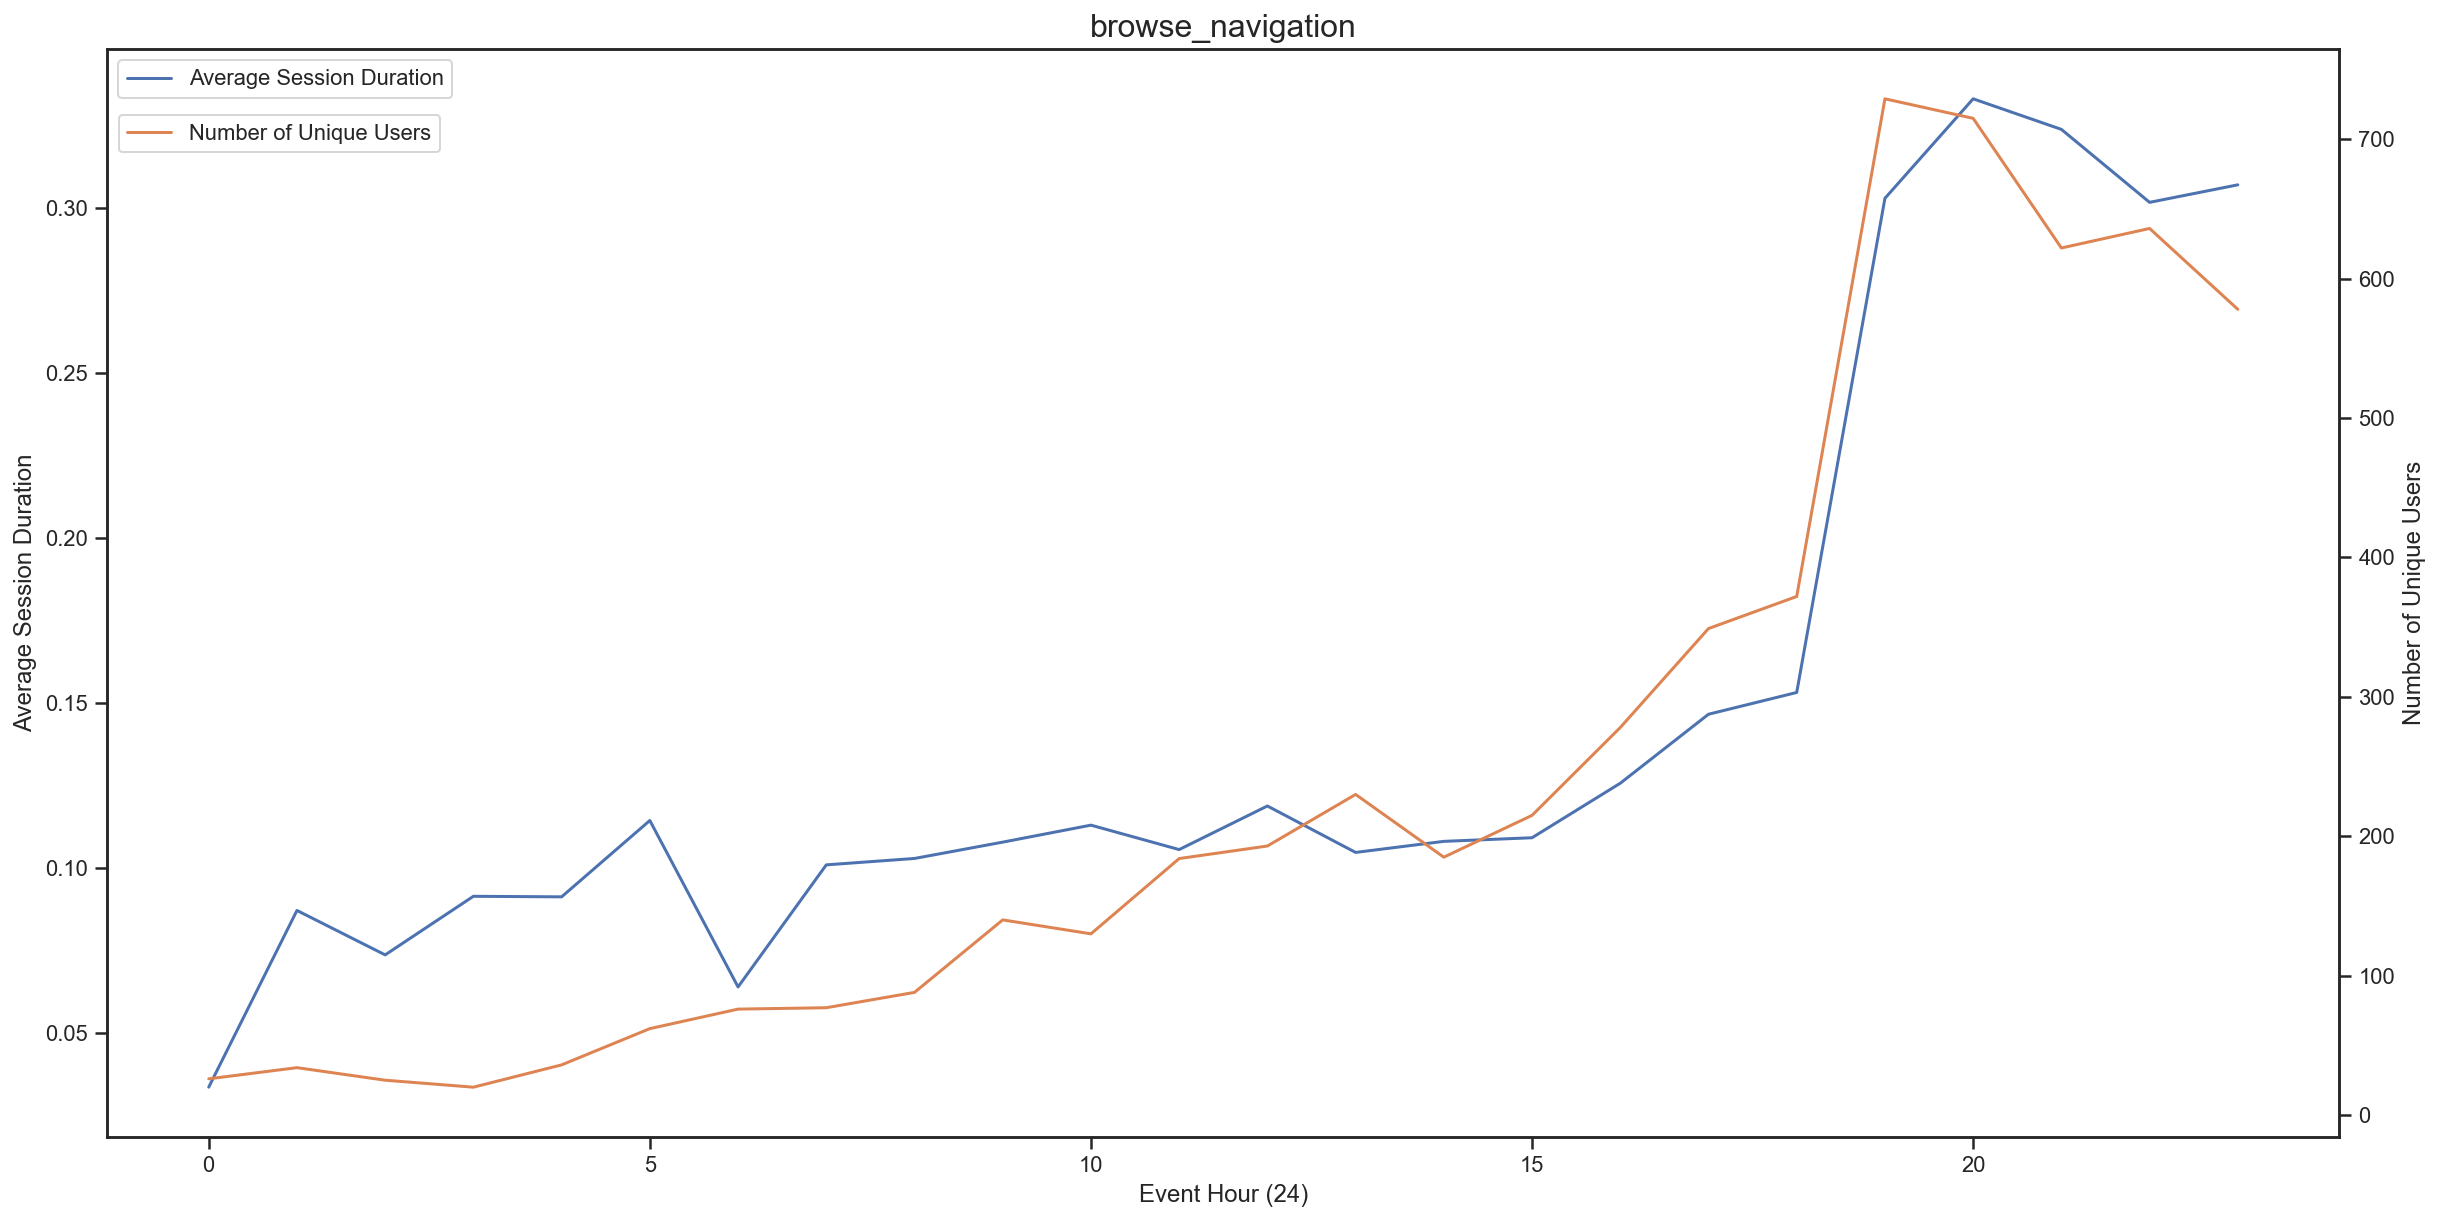

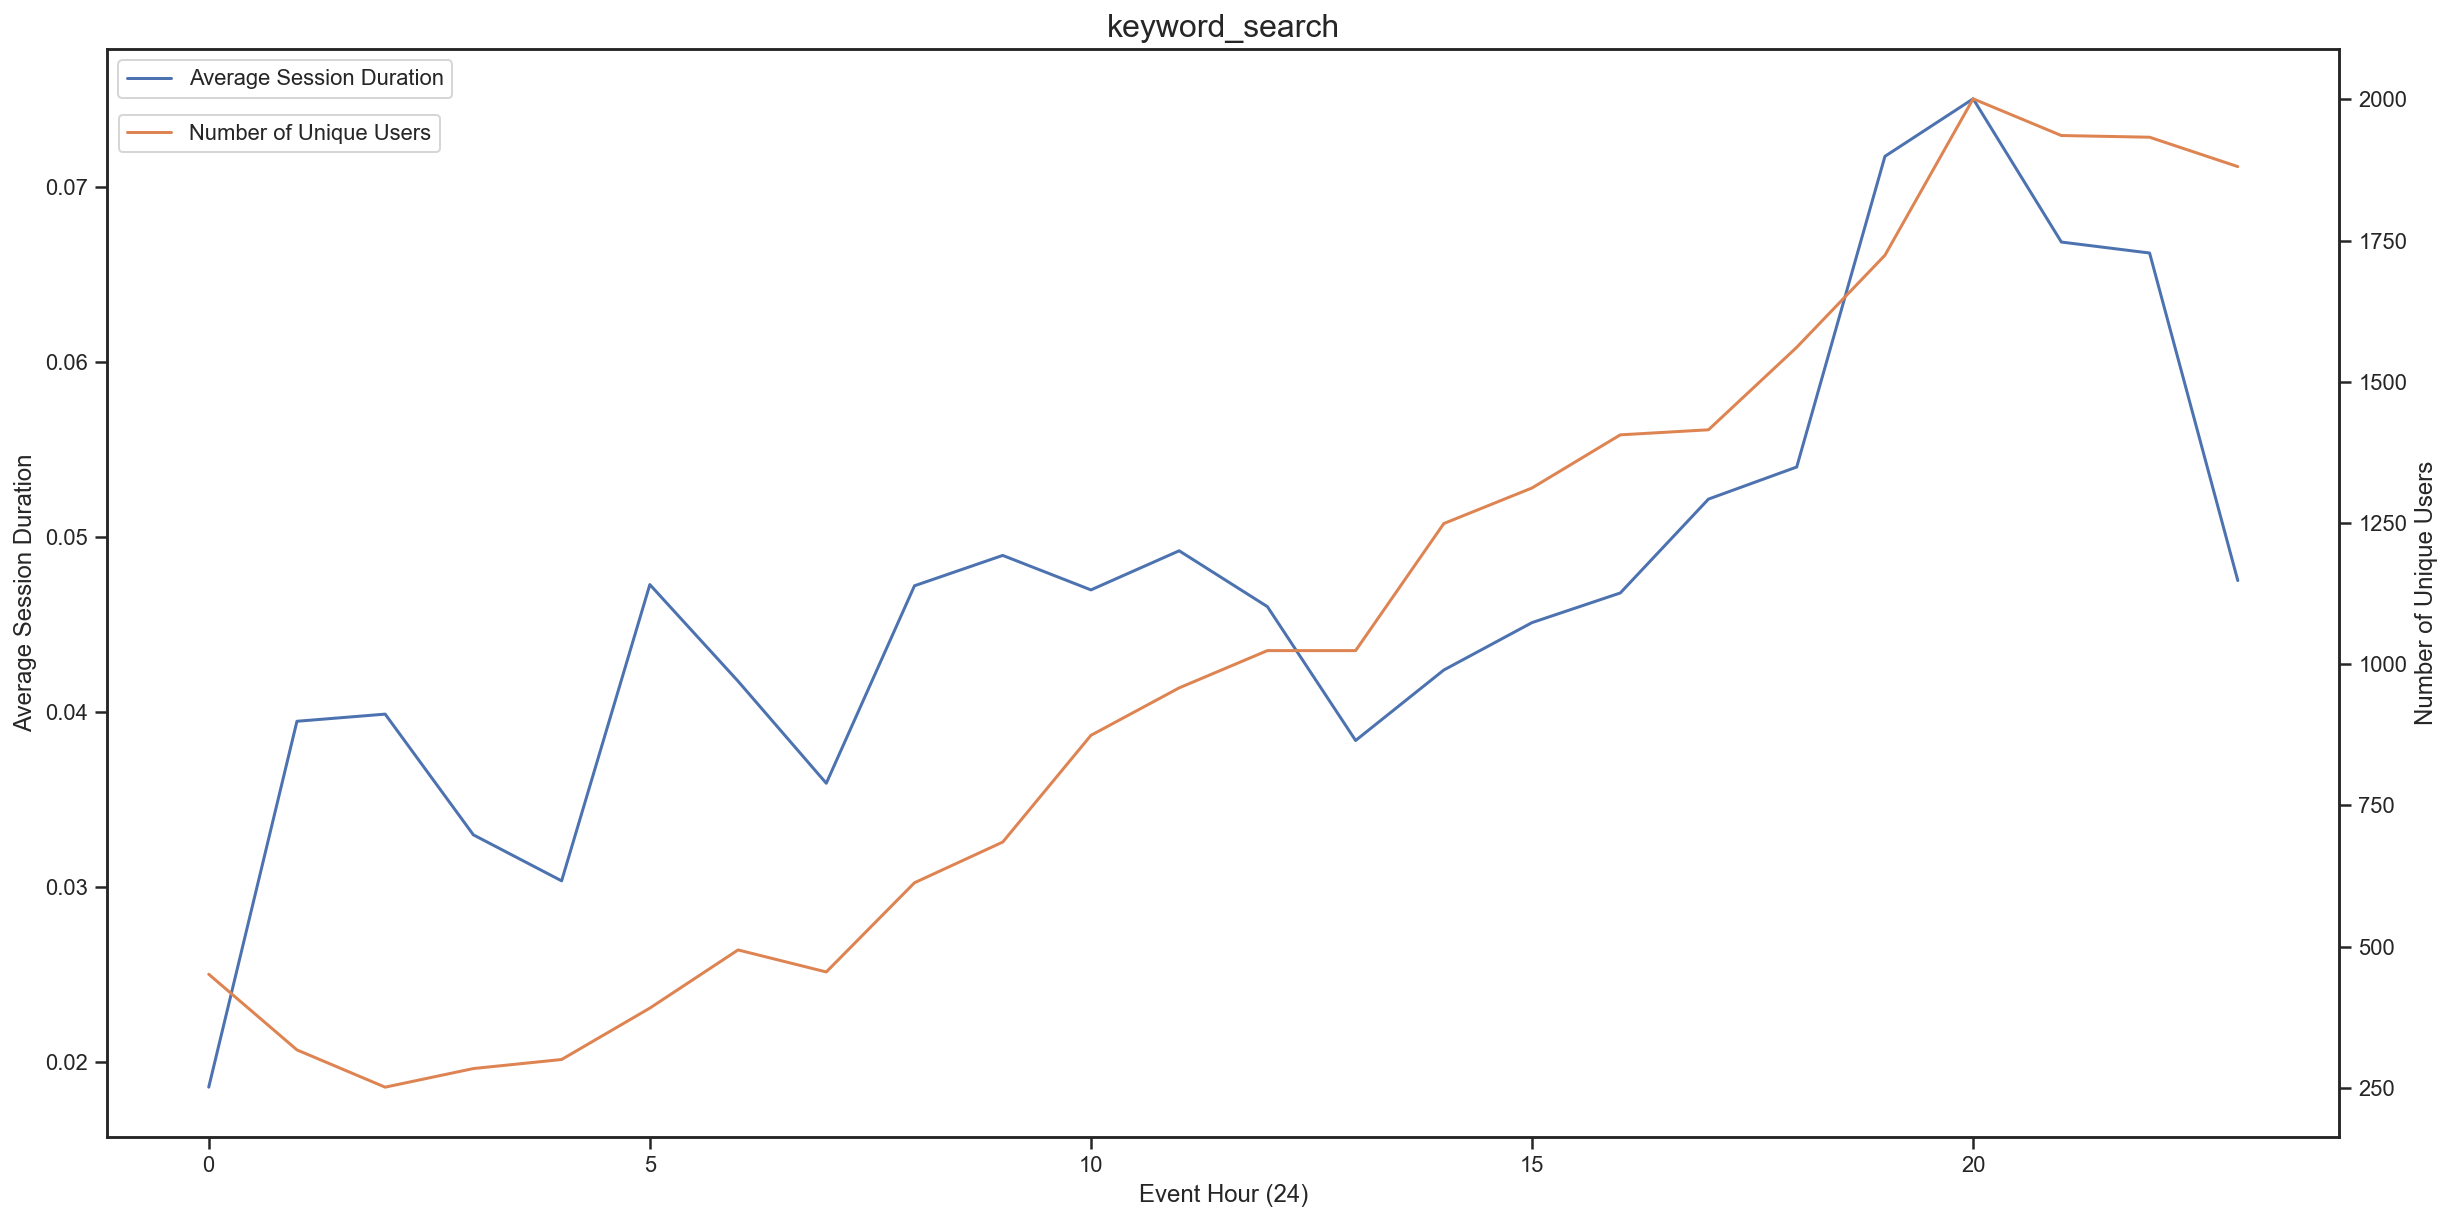

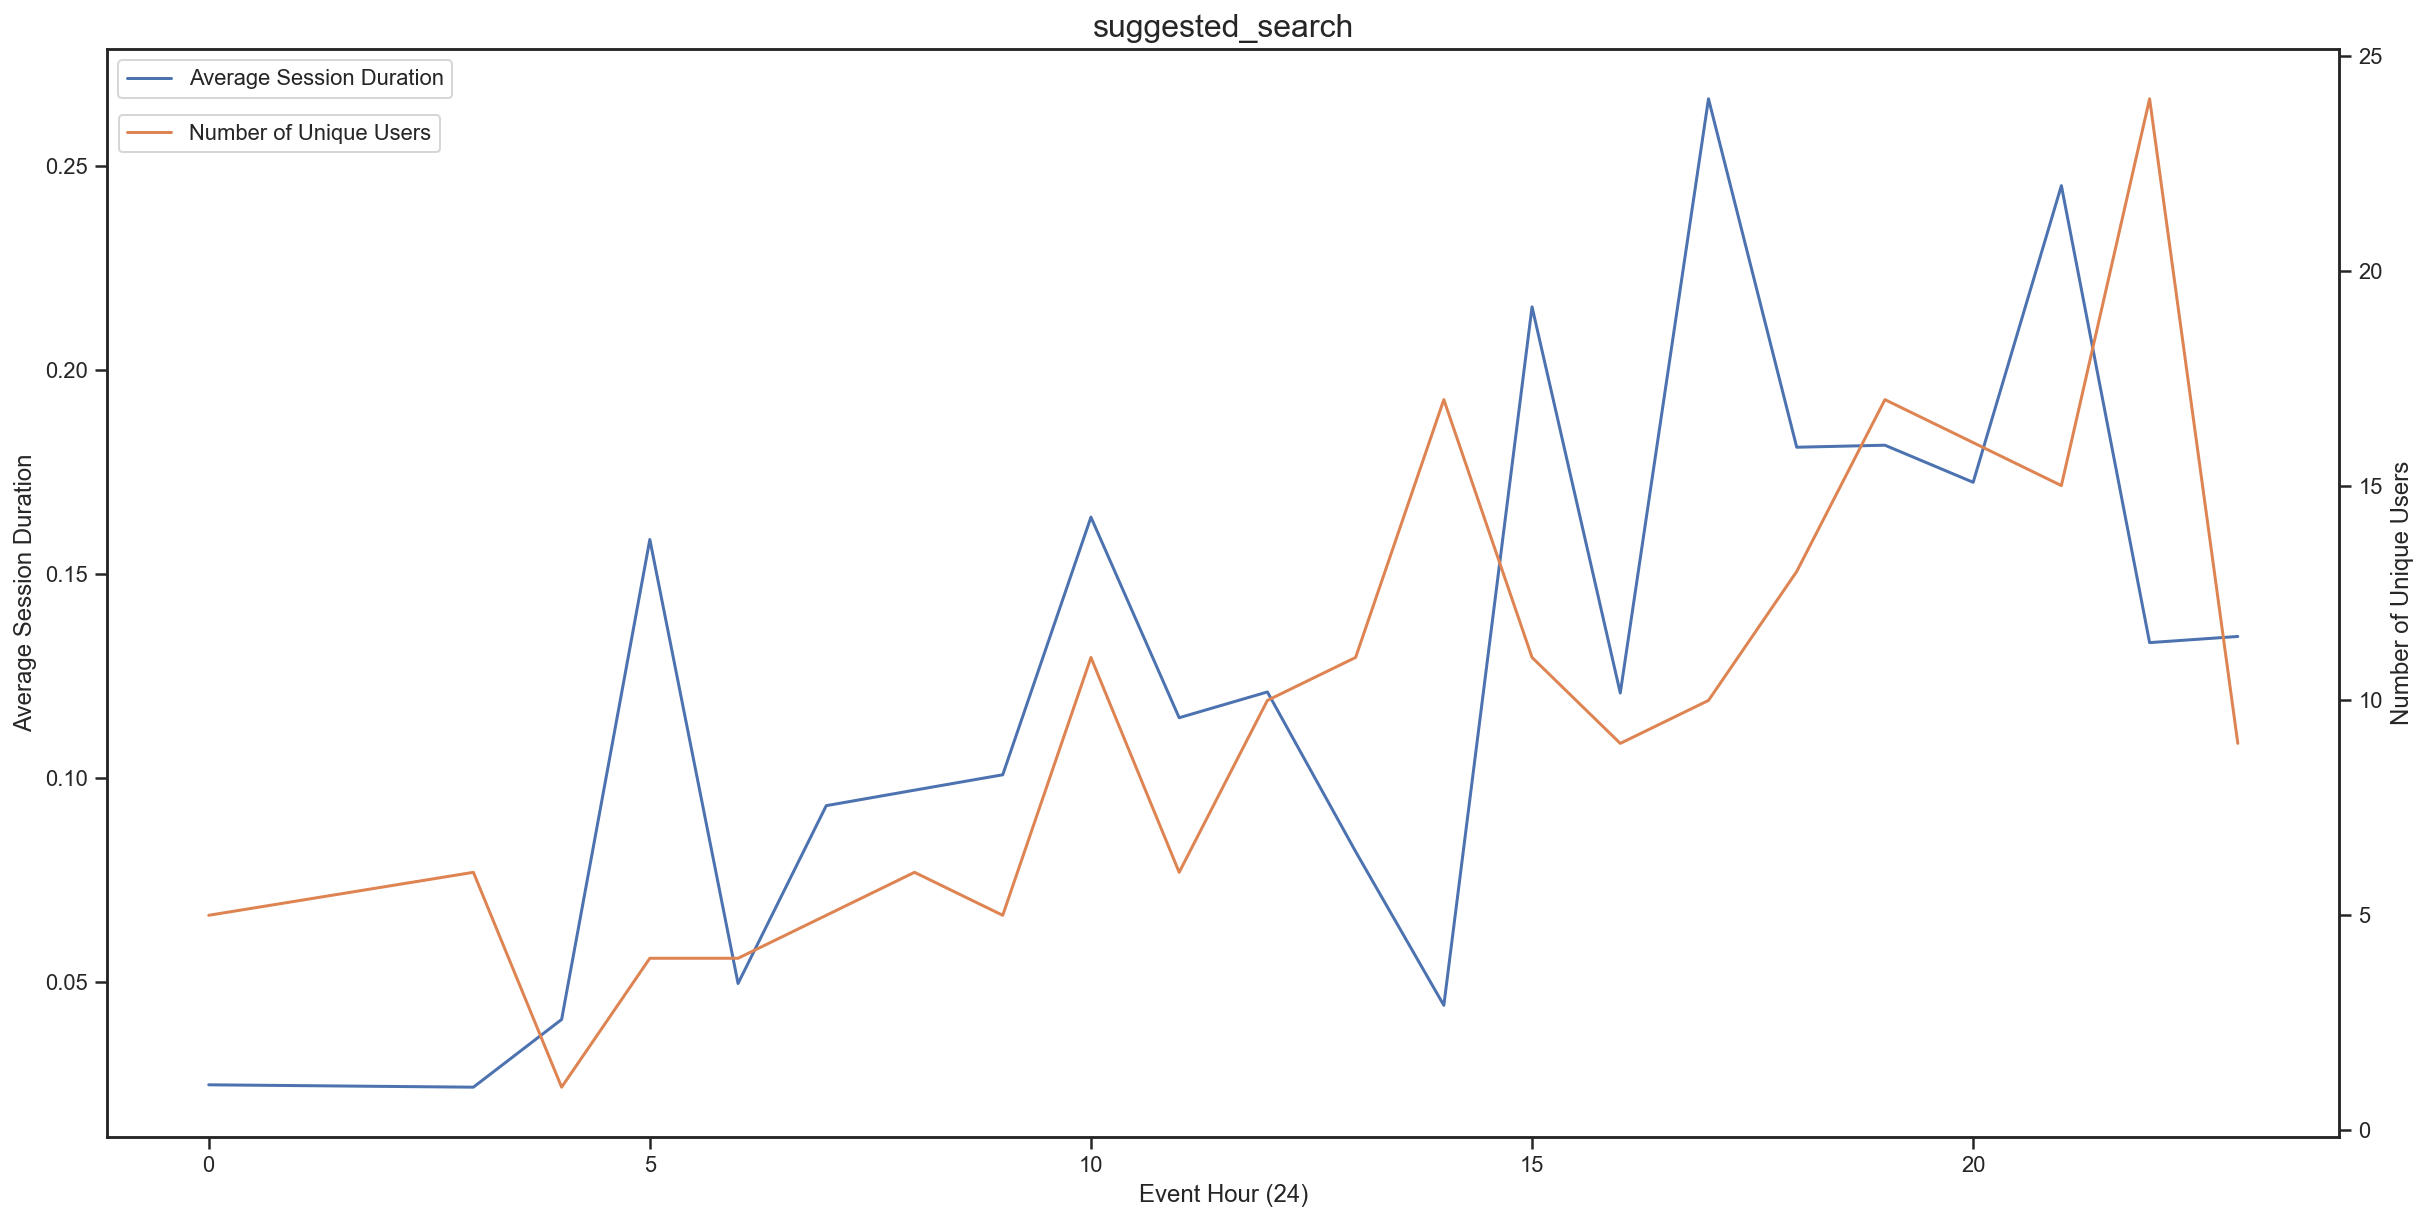

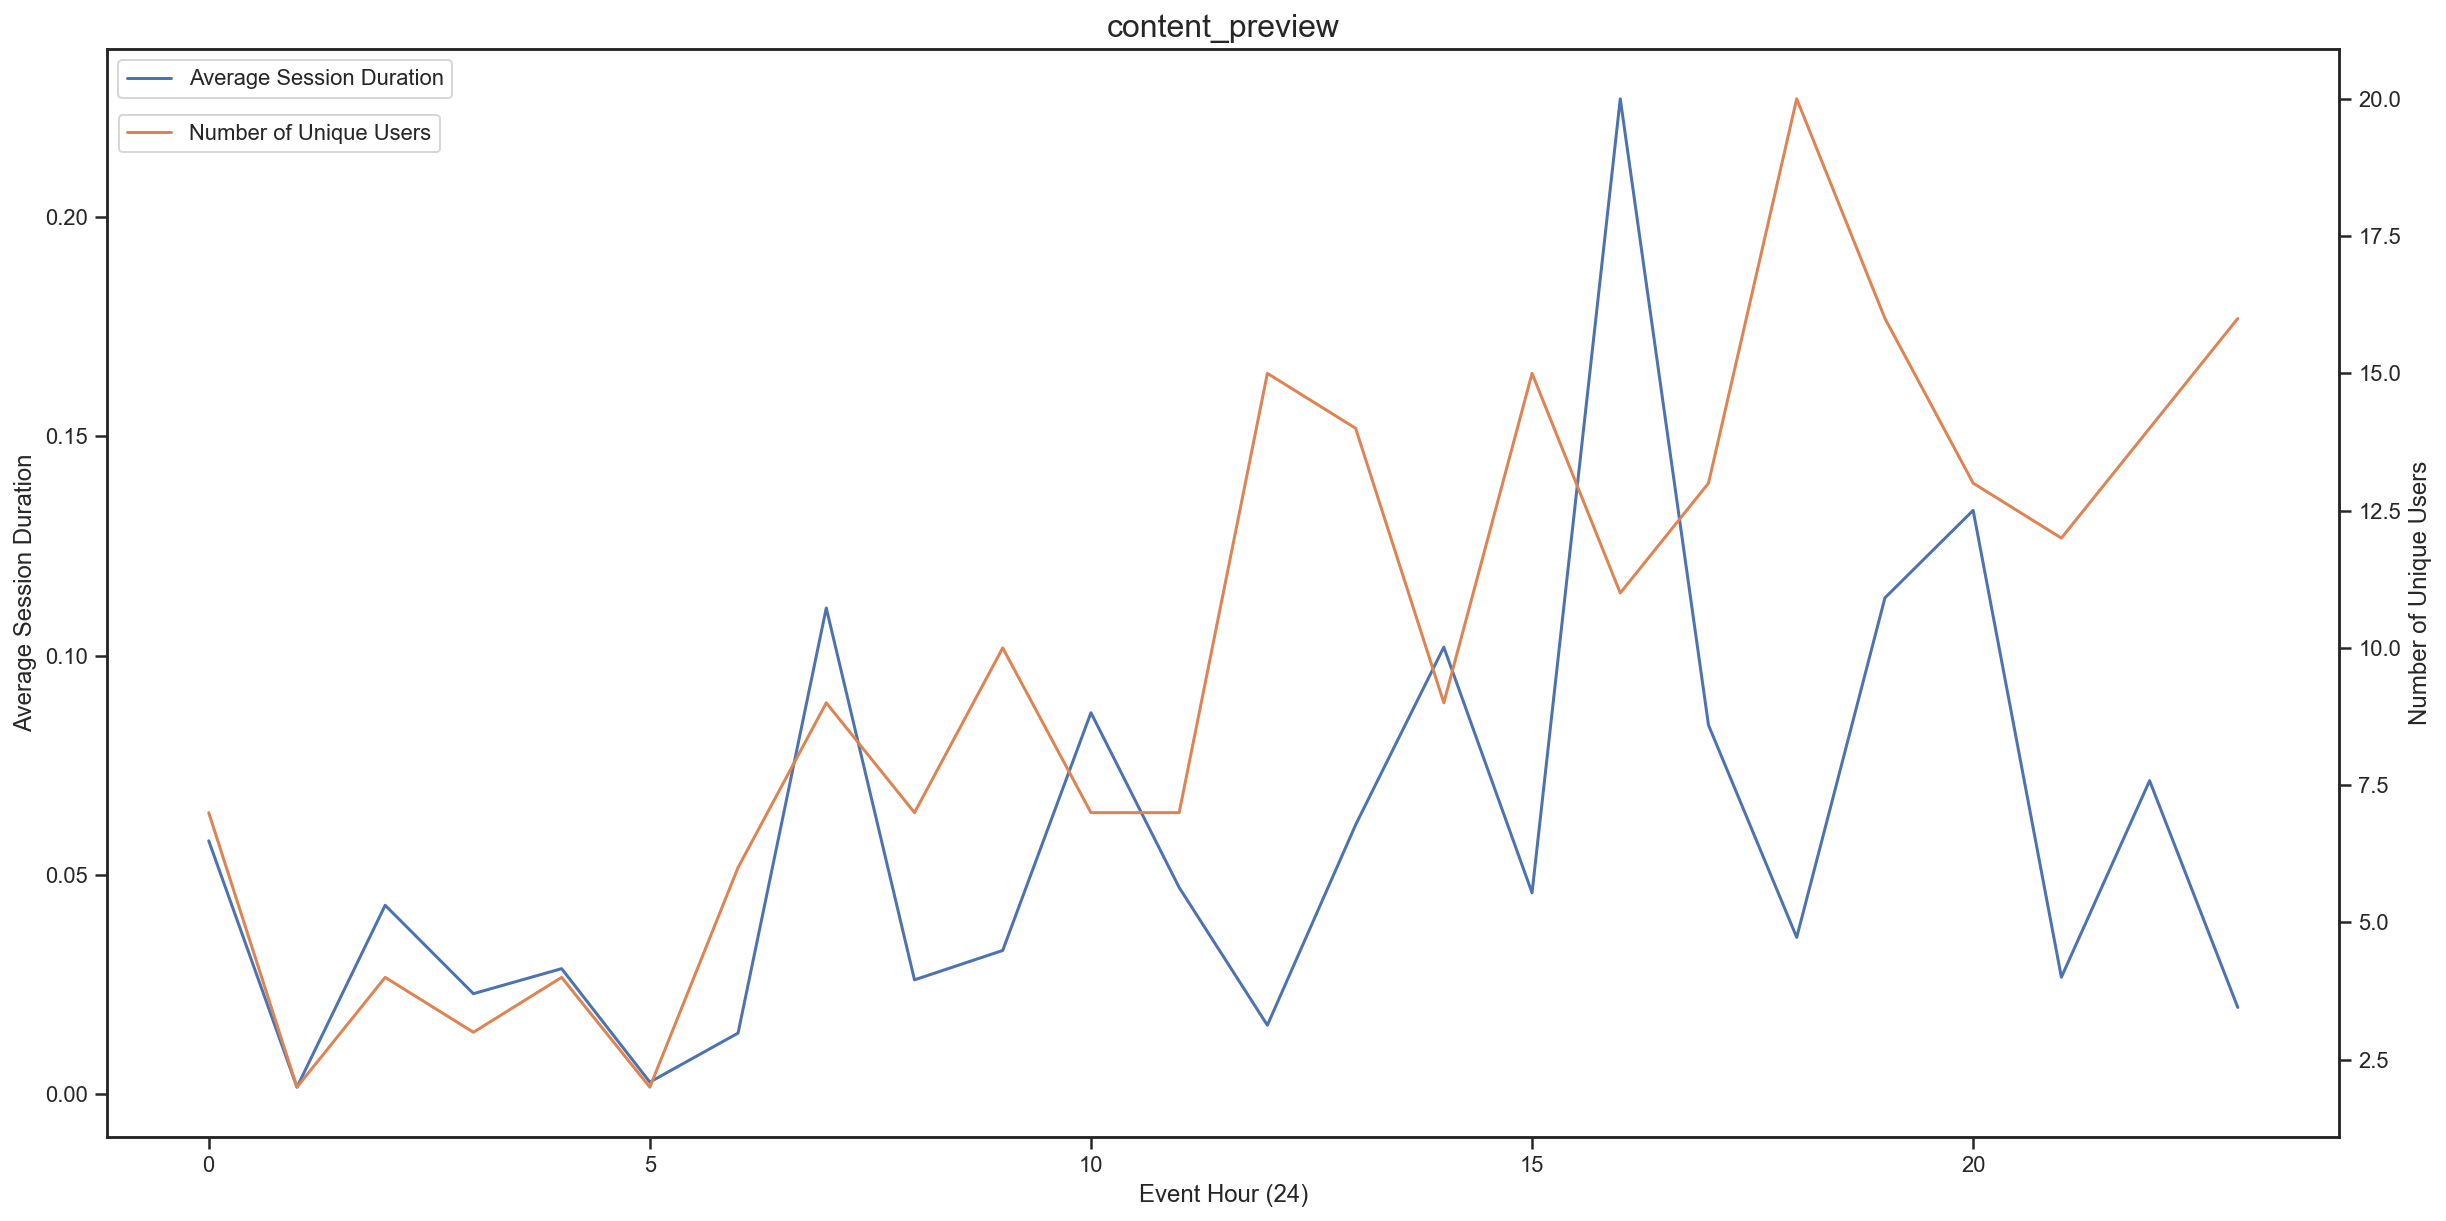

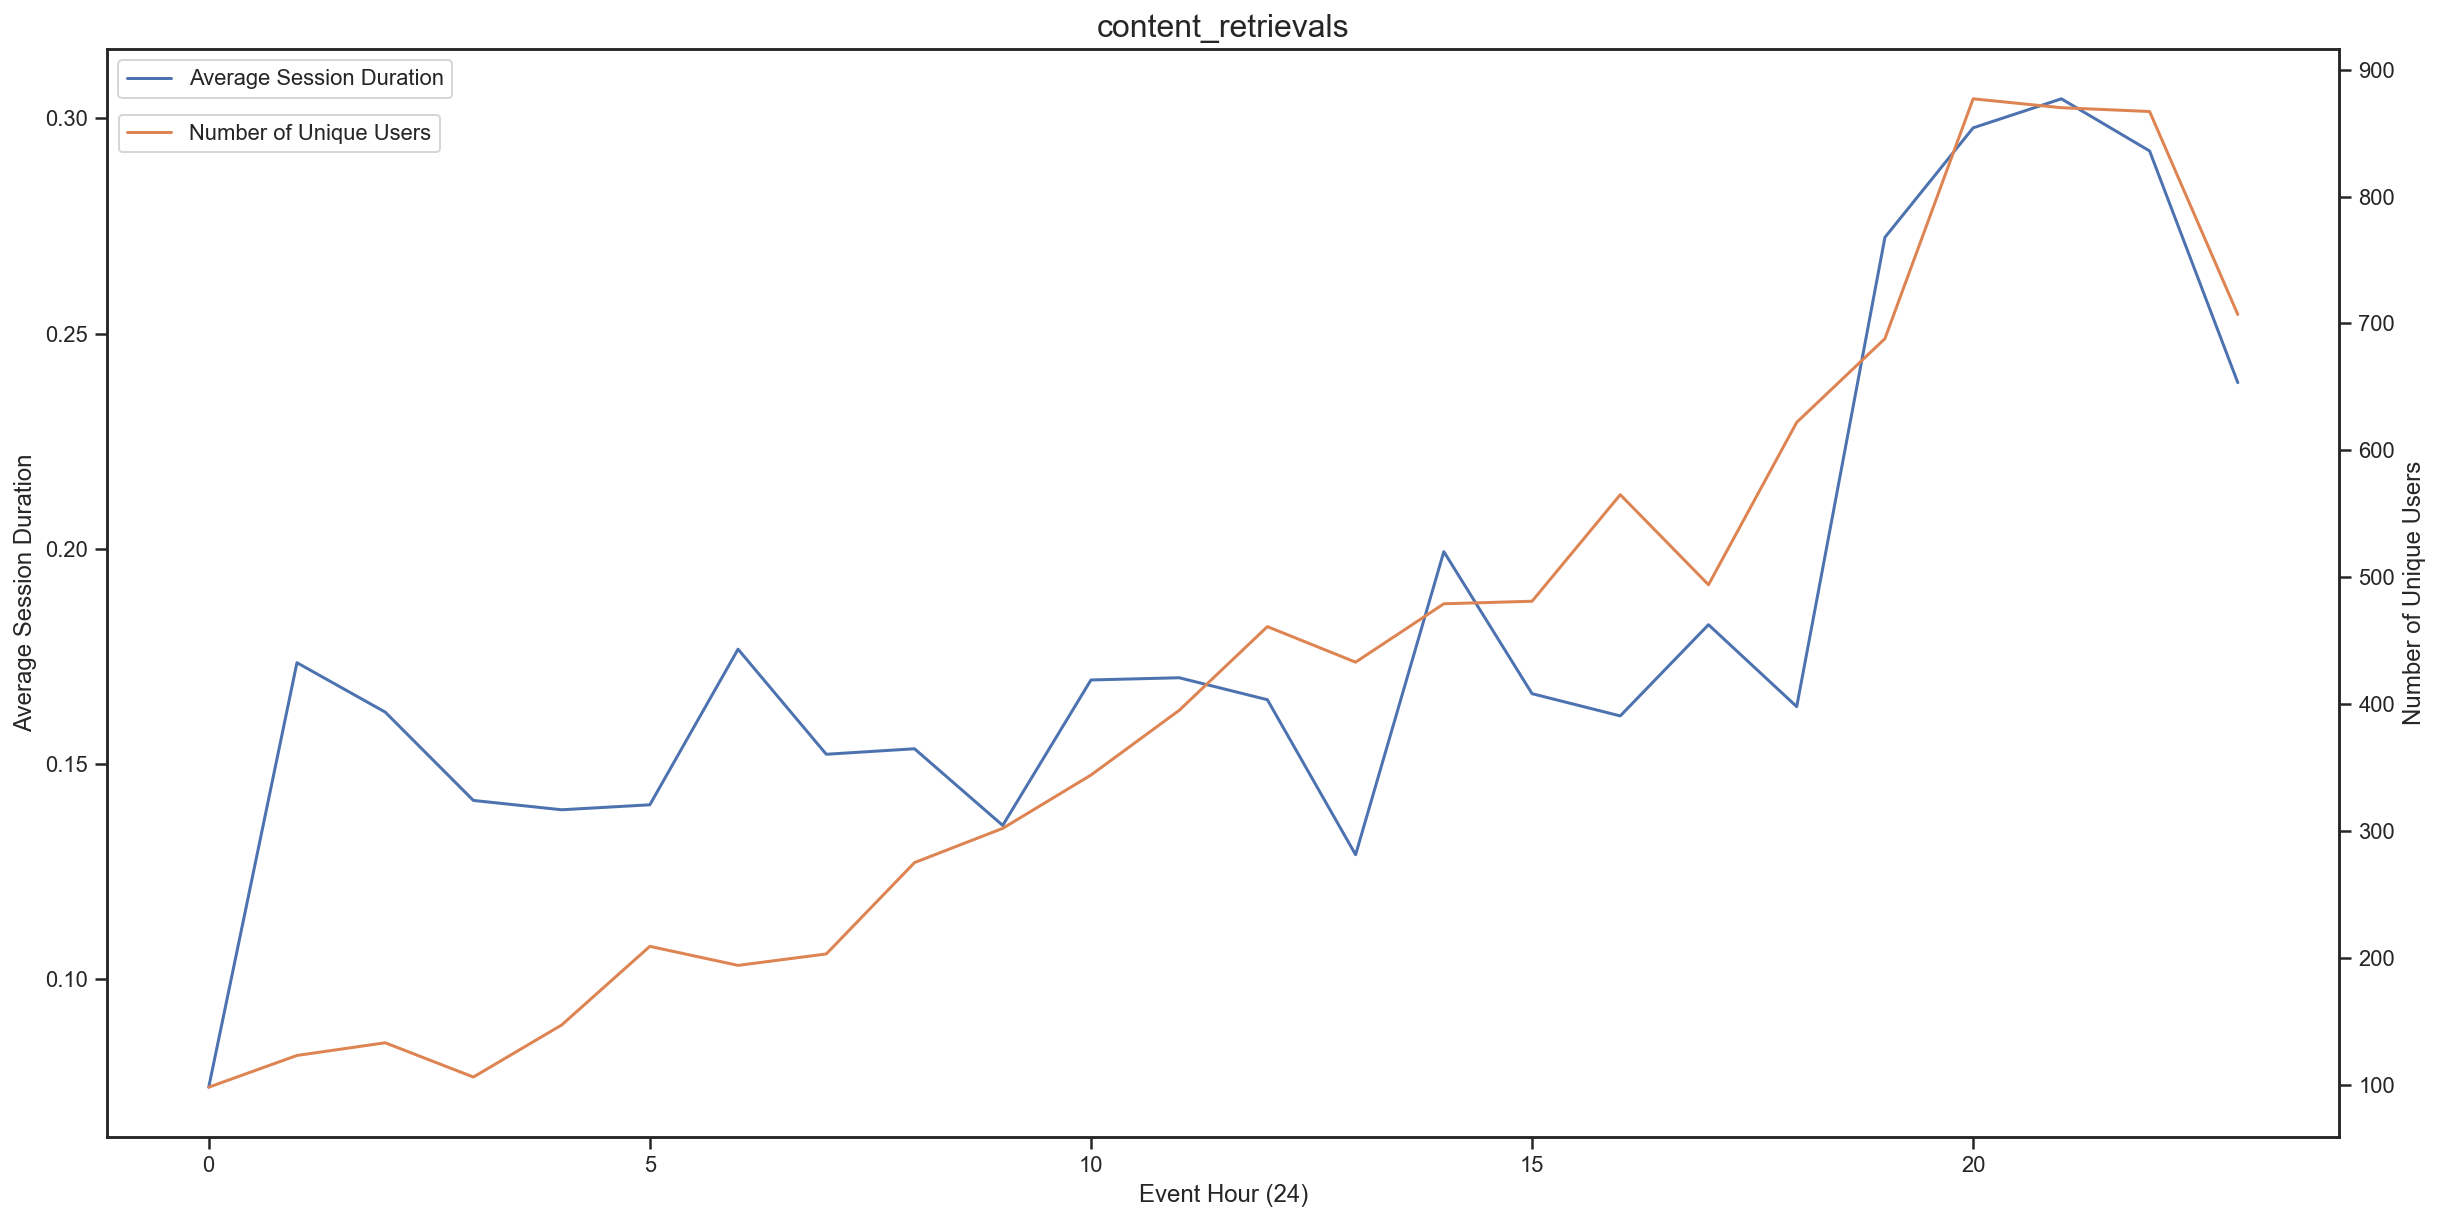

In [7]:
for name in table_names:
    plot_event_session_duration_user_relationship(name)

In [84]:
for name in table_names:
    df = pandas.read_sql("SELECT session_duration from {}".format(name), connection)
    print(name)
    print(df.describe())
    print()

browse_navigation
       session_duration
count       8169.000000
mean           0.224822
std            0.246725
min            0.000035
25%            0.033900
50%            0.123113
75%            0.341562
max            1.136076

keyword_search
       session_duration
count      32068.000000
mean           0.052730
std            0.064944
min            0.000000
25%            0.008044
50%            0.028102
75%            0.068785
max            0.574653

suggested_search
       session_duration
count        222.000000
mean           0.141940
std            0.172677
min            0.000266
25%            0.019271
50%            0.078507
75%            0.201852
max            0.970637

content_preview
       session_duration
count        236.000000
mean           0.065592
std            0.126553
min            0.000035
25%            0.000712
50%            0.012454
75%            0.071186
max            0.900162

content_retrievals
       session_duration
count      11367.000000

---

In [67]:
df = pandas.read_sql("SELECT event_time, query, media_types from keyword_search where session_duration != 0",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

multi_media = df.query('media_types.str.contains(",") | media_types == "all"').copy()
df = df[~df.index.isin(multi_media.index)].copy()
for (i, row) in multi_media.iterrows():
    new_rows = []
    if "," in row["media_types"]:
        new_rows += [{"query" : row["query"], "event_hour" : row["event_hour"], "media_types" : m}
                     for m in row["media_types"].split(",")]
    else:
        new_rows += [{"query" : row["query"], "event_hour" : row["event_hour"], "media_types" : m} for m in
                     ["text", "photo", "video", "audio", "graphic"]]
    df = df.append(new_rows, ignore_index=True)
    
df["query"] = df["query"].apply(str.lower)
df["query"] = df["query"].apply(lambda x : ("joe biden" if x == "biden" else
                                           ("donald trump" if x == "trump" else x)))

In [68]:
g = df.groupby(["query", "media_types", "event_hour"]).size().reset_index()
g = g.groupby(["media_types", "event_hour"]).apply(
    lambda x: (x["query"].iloc[argmax(x[0])], max(x[0]))).reset_index()
g.pivot(index="event_hour", values=0, columns="media_types")

media_types,audio,graphic,photo,text,video
event_hour,,,,,
0,"(donald trump, 5)","(donald trump, 5)","(donald trump, 43)","(rfk stadium, 17)","(donald trump, 8)"
1,"(kamala harris, 8)","(kamala harris, 8)","(donald trump, 13)","(kamala harris, 8)","(donald trump, 10)"
2,"(donald trump, 4)","(miss piggy, 5)","(donald trump, 9)","(donald trump, 7)","(donald trump, 13)"
3,"(bruce arians, 3)","(bruce arians, 3)",(subjects.code:86b08df87dac1004890cba7fa5283c3...,"(coronavirus aptopix, 8)","(vienna, 7)"
4,"(erdoğan macron, 4)","(erdoğan macron, 4)","(donald trump, 20)","(vienna, 9)","(donald trump, 15)"
5,"(sportsminute, 5)","(ruth bader ginsburg, 5)","(donald trump, 11)","(election, 8)","(donald trump, 6)"
6,"(us election, 7)","(donald trump, 6)","(donald trump, 31)","(us election, 18)","(joe biden, 7)"
7,"(donald trump, 12)","(donald trump, 14)","(donald trump, 24)","(donald trump, 16)","(donald trump, 13)"
8,"(eta, 11)","(eta, 11)","(donald trump, 32)","(donald trump, 19)","(donald trump, 13)"


In [69]:
top_10 = df.groupby(["query"]).size().reset_index().sort_values(by=0, ascending=False)[0:10]
top_10

,query,0
3348,donald trump,2811
5477,joe biden,2177
3558,election,1208
5159,indiana,461
9943,vienna,460
4286,florida,411
9719,us election,407
3560,election 2020,363
3541,elecciones,356
5080,illinois,347


<AxesSubplot:xlabel='event_hour', ylabel='count'>

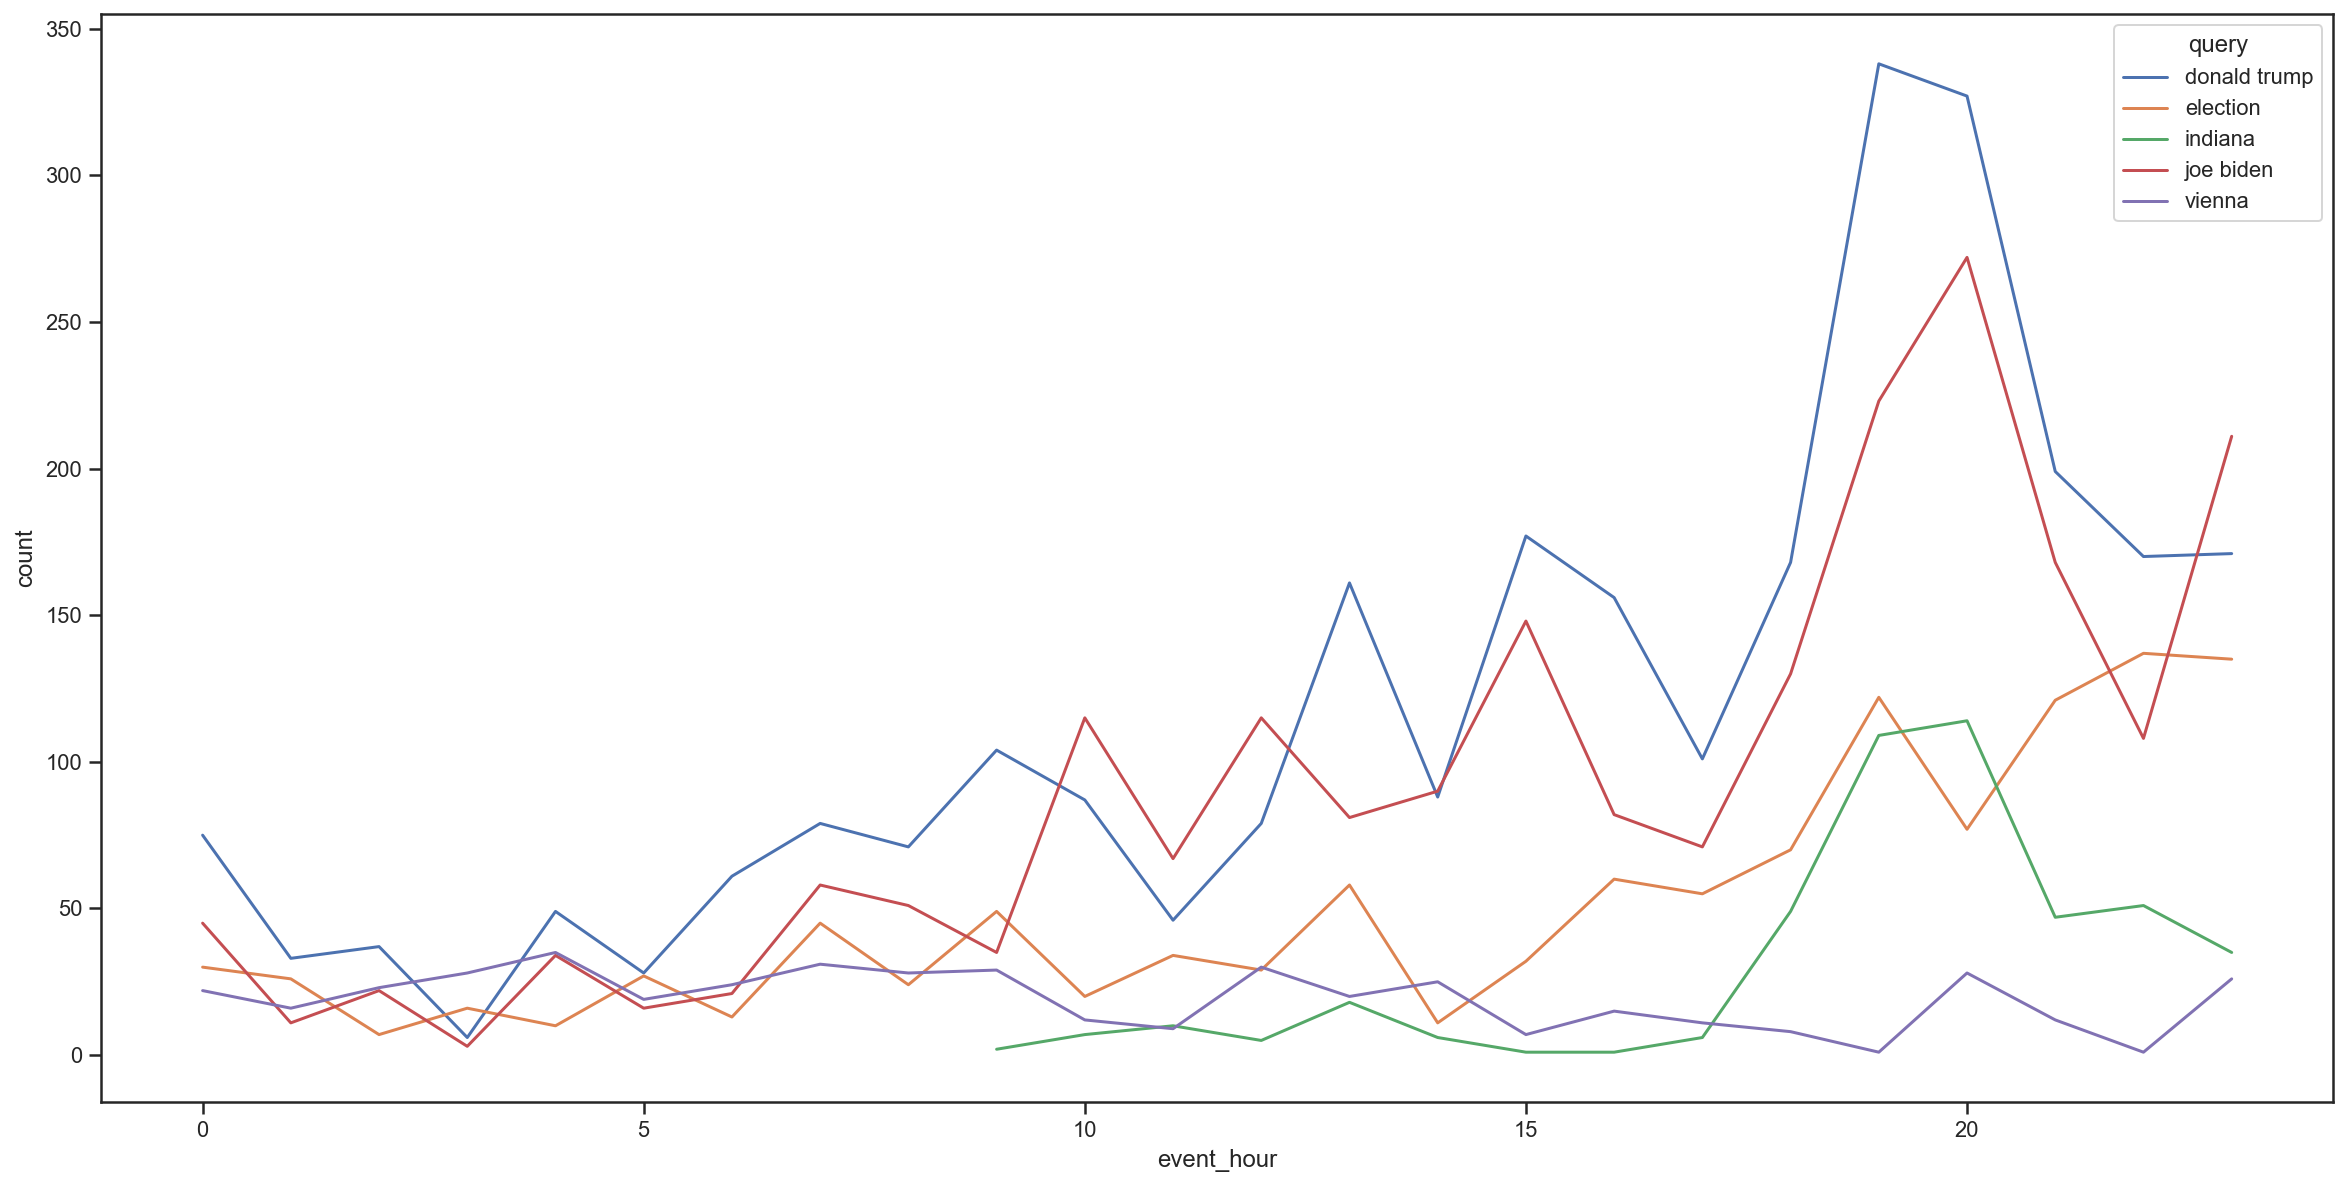

In [70]:
top_5_per_hour = df[df["query"].isin(top_10["query"][0:5])].groupby(["query", "event_hour"]).size().reset_index()
top_5_per_hour = top_5_per_hour.rename(columns={0 : "count"})
sns.lineplot(data=top_5_per_hour, x="event_hour", y="count", hue="query")

---

In [78]:
df = pandas.read_sql("SELECT event_time, event_label, event_category, retrievals_count from content_retrievals",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

In [73]:
top_10 = df.groupby(["event_label"]).agg({"retrievals_count" : "sum"}).reset_index().sort_values(
    by="retrievals_count", ascending=False)[0:10]
top_10

,event_label,retrievals_count
2863,US--Election 2020-The Latest,519
2838,US--Election 2020,342
1394,Election 2020 Trump,157
1182,Election 2020 Biden,146
2834,US--APNewsAlert,142
2856,US--Election 2020-Senate,127
2869,US--Election 2020-Voting,97
2861,US--Election 2020-Senate-The Latest,88
1914,LT--Tropical Weather,72
2943,US--Virus-Outbreak,63


In [77]:
g = df.groupby(["event_label", "event_hour", "event_category"]).agg({"retrievals_count" : "sum"}).reset_index()
g = g.groupby(["event_hour", "event_category"]).apply(
    lambda x: (x["event_label"].iloc[argmax(x["retrievals_count"])], max(x["retrievals_count"]))).reset_index()
g.pivot(index="event_hour", values=0, columns="event_category")

event_category,BulkDownloadFromDetailPage-Confirm,Copy Control C,Copy Photo Caption,Download Selected Confirm,Print Story,Send To Webfeeds,StandardDownload
event_hour,,,,,,,
0,"(7c0fd96f145930d1b487531c2feae60b, ec627cd7fb1...","(DEP-NFL BUCCANEERS-GIANTS, 3)",NaN,"(20c0c7bd8ec34d65989e52151d77ec43, dbc138b2e3f...",(Asia Today: New Delhi sees worst wave as Indi...,NaN,"(Buccaneers Giants Football, 2)"
1,"(e0c66823d2a6a3d15d565e098a83fc29, 74a83e1d1a9...","(US--Election 2020-The Latest, 7)",NaN,NaN,(4 dead in Vienna shooting; attacker sympathiz...,NaN,"(Election 2020 The Day in Photos, 4)"
2,"(d3ee56012562c6110faf6b9e92b0fd03, 84c044cd9da...","(Election 2020-Anxious Voters, 8)",NaN,NaN,(Powerful Hurricane Eta threatens flooding in ...,NaN,"(Election 2020 The Day in Photos, 7)"
3,"(10772708174543a3bcb9511dfee0b6b9,, 1)","(Election 2020-Anxious Voters, 8)",NaN,NaN,(France says its forces kill 50 Islamic extrem...,NaN,"(Austria Vienna Attack, 3)"
4,"(c629a7fe4c1a46b88e4ebb7ff0b16b0d, 842579a02eb...","(EU--Austria-Vienna-Attack, 10)",NaN,NaN,"(AM Prep-Kickers, 1)",NaN,"(Austria Vienna Attack, 4)"
5,"(c629a7fe4c1a46b88e4ebb7ff0b16b0d, 842579a02eb...","(EU--Austria-Vienna-Attack, 9)",NaN,NaN,"(AM Prep-Cooler Copy, 1)",NaN,"(Austria Vienna Attack, 7)"
6,"(7c0fd96f145930d1b487531c2feae60b, ec627cd7fb1...","(Explaining the Election-States to Watch, 9)",NaN,"(878f2343220f4fb8b5fb7173e0ec6dd2, de11df08289...","(Today in History, 1)",NaN,"(Austria Vienna Attack, 7)"
7,"(7c0fd96f145930d1b487531c2feae60b, ec627cd7fb1...","(Sports Right Now, 11)",NaN,NaN,"(AM Prep-Cyber Corner, 1)",NaN,"(Austria Police Operation, 3)"
8,"(55694d7fbe5f4261a3037745ce593151, 1c9f6476890...","(US--Election 2020, 13)",NaN,"(5fa5b49ca3c243cd8ad12ec3209b3127,, 1)",(Ferrari profit steady as it recovers lost loc...,NaN,"(Austria Vienna Attack, 8)"


---

In [80]:
df = pandas.read_sql("SELECT event_time, event_label, event_category from content_preview",
                     connection, parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

In [81]:
g = df.groupby(["event_label", "event_hour", "event_category"]).size().reset_index()
g = g.groupby(["event_hour", "event_category"]).apply(
    lambda x: (x["event_label"].iloc[argmax(x[0])], max(x[0]))).reset_index()
g.pivot(index="event_hour", values=0, columns="event_category")

event_category,StandardPreview,Story Details- View Image's Metadata,Story Display
event_hour,,,
0,"(AMN-CLI TORMENTAS, 1)",NaN,NaN
1,"(Race Riot-Florida, 1)",NaN,NaN
2,"(Austria Shooting Attack Update, 1)",NaN,NaN
3,"(Election 2020 Trump, 1)","((not set), 2)",NaN
4,"(AS--Afghanistan, 1)",NaN,NaN
5,"(Election 2020 Biden, 1)",NaN,NaN
6,"(AM Prep-Segue, 1)",NaN,NaN
7,"(LT--Tropical Weather, 2)",NaN,NaN
8,"(AMN-POL EEUU-ELECCIONES-DESAFIOS LEGALES, 1)",NaN,"(Body Only, 2)"


---

In [87]:
df = pandas.read_sql("SELECT event_time, event_label from browse_navigation", connection,
                     parse_dates={"event_time" : "%H:%M"})
df["event_hour"] = df["event_time"].dt.hour
del df["event_time"]

150

In [89]:
g = df.groupby(["event_hour", "event_label"]).size().reset_index()
g = g.groupby(["event_hour"]).apply(lambda x: (x["event_label"].iloc[argmax(x[0])], max(x[0]))).reset_index()
g

,event_hour,0
0,0,"((not set), 4)"
1,1,"(Top News, 6)"
2,2,"((not set), 6)"
3,3,"((not set), 5)"
4,4,"((not set), 8)"
5,5,"((not set), 14)"
6,6,"((not set), 18)"
7,7,"((not set), 19)"
8,8,"((not set), 20)"
9,9,"((not set), 29)"
